# Organoid quantification

This notebook detects and quantifies organoid size. It uses the model trained for [OrgaQuant](https://github.com/TKassis/OrgaQuant). The notebook contains several steps:

1. Mounting the Google Drive to access data
2. Installing and loading dependencies 
3. Setting paramters for organoid detection
4. Batch quantify all images in the folder

Google Drive instructions
- Ensure that the shared `organoid_quant` directory is placed in the Google Drive root
- Ensure that images to be quantified are placed within a subdirectory in `organoid_quant/images`

## 1. Mount the Google Drive to access data

Follow the link and instructions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !git clone https://github.com/TKassis/OrgaQuant.git

In [2]:
!git status

fatal: not a git repository (or any of the parent directories): .git


## 2. Install and load dependencies

In [0]:
%cd drive/My\ Drive/OrgaSwell/OrgaQuant

# Building keras-resnet
!pip install -q keras-resnet==0.2.0 # cython keras matplotlib opencv-python
!python setup.py build_ext --inplace -q
%cd ..

# Supress tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

%tensorflow_version 1.x

import ipywidgets as widgets
from google.colab.patches import cv2_imshow
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow import keras
from OrgaQuant.keras_retinanet import models
from OrgaQuant.keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image, adjust_contrast
from OrgaQuant.keras_retinanet.utils.visualization import draw_box
import numpy as np
import pandas as pd

tf.logging.set_verbosity(tf.logging.ERROR)

def load_orga_model():
  model = models.load_model("OrgaQuant/trained_models/orgaquant_intestinal_v2.h5", backbone_name='resnet50')
  return model

model = load_orga_model()

/content/drive/My Drive/organoid_quant/OrgaQuant
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
/content/drive/My Drive/organoid_quant


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## 3. Setting paramteres for organoid detection





In [0]:
slider_min_side = widgets.IntSlider(value=1800, min=800, max=2000, step=100, description='Min Side:',
                                    description_tooltip='Larger "Image Size" allows you to detect smaller orgaoids at the cost of computational demand.')
slider_contrast = widgets.FloatSlider(value=2, min=1, max=3, step=0.25, description='Contrast', 
                                      description_tooltip='Larger "Contrast" can improve detection sometimes.')
slider_threshold  = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.05, description='Threshold', 
                                        description_tooltip='Use larger "Threshold" to eliminate false positives.')
slider_seed = widgets.IntSlider(value=1, min=1, max=40, step=1, description='Seed',
                                    description_tooltip='Change value if parameter optimization should be performed on another image')

dropdown_path = widgets.Dropdown(options=[x.name for x in Path('./images').iterdir() if x.is_dir()], description='Directory:',disabled=False)

display(dropdown_path, slider_min_side, slider_contrast, slider_threshold, slider_seed)

IntSlider(value=1800, description='Min Side:', description_tooltip='Larger "Image Size" allows you to detect s…

FloatSlider(value=2.0, description='Contrast', description_tooltip='Larger "Contrast" can improve detection so…

FloatSlider(value=0.9, description='Threshold', description_tooltip='Use larger "Threshold" to eliminate false…

IntSlider(value=1, description='Random Seed', description_tooltip='Change value if parameter optimization shou…

Dropdown(description='Directory:', options=('Matrigel coated plate 2', 'FDA screen 113 FDA1 n1'), value='Matri…

Adjust the sliders and assess image generated by the cell below. If output is not as required, change settings and try again. The current values are manually optimized by Remco. 

Set the folder that contains image data.

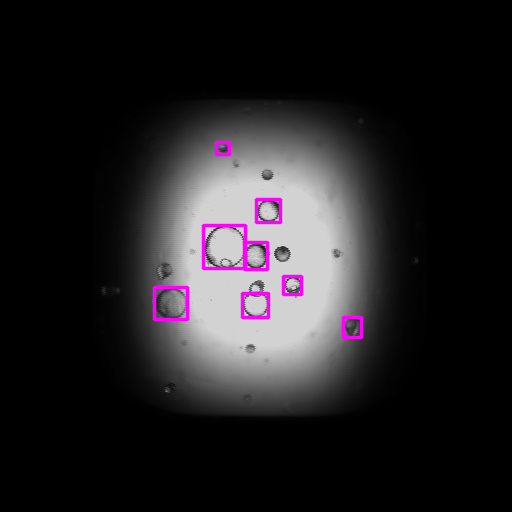

(8, None)

In [0]:
min_side = slider_min_side.value
contrast = slider_contrast.value
threshold = slider_threshold.value
seed = slider_seed.value
folder_path = Path('./images') / dropdown_path.value

imagelist = [i for i in Path(folder_path).glob('**/*.jpg') if '_detected' not in str(i)]

np.random.seed(seed)
# load image
image = read_image_bgr(np.random.choice(imagelist, size=1)[0])

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = adjust_contrast(image,contrast)
image = preprocess_image(image)
image, scale = resize_image(image, min_side=min_side, max_side=2048)

# process image
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

# correct for image scale
boxes /= scale

num_org = 0
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < threshold:
        break
    num_org= num_org + 1
    b = box.astype(int)
    draw_box(draw, b, color=(255, 0, 255))

num_org, cv2_imshow(draw)

## 4. Batch quantify all images in the folder

This will take a while depending on the number of images and the value set for min side. 

For each image, an csv and jpg are created in the same directory. The CSV contains the quantification for the image, and the jpg contains annotation of the detected organoids

### Quantitative output
2 files will be created in the parent directory:

- output.csv: containing sizes for all detected organoids
- output_summary.csv: containing mean organoid size, std of the organoid size and number of detected orgaoinds for each well and each timepoint.

In [0]:
for i, IMAGE_PATH in enumerate(imagelist):
  # print(, end='\r')
  print('\r', f'analysing image: {i+1} of {len(imagelist)}', end='')
  # load image
  image = read_image_bgr(IMAGE_PATH)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = adjust_contrast(image,contrast)
  image = preprocess_image(image)
  image, scale = resize_image(image, min_side=min_side, max_side=2048)

  # process image
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

  # correct for image scale
  boxes /= scale

  out = np.empty((0,4), dtype=np.float32)
  out_scores = []

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < threshold:
          break
      out = np.append(out, box.reshape(1,4), axis=0)
      out_scores.append(score)

      b = box.astype(int)
      draw_box(draw, b, color=(255, 0, 255))

  output = pd.DataFrame(out,columns=['x1', 'y1', 'x2', 'y2'], dtype=np.int16)
  output['score'] = out_scores
  output['Diameter 1 (Pixels)'] = output['x2'] - output['x1']
  output['Diameter 2 (Pixels)'] = output['y2'] - output['y1']
  output.to_csv(str(IMAGE_PATH) + '.csv', index=False)
  plt.imsave(str(IMAGE_PATH) + '_detected.png', draw)
print('\n done')

 analysing image: 169 of 169
 done


In [0]:
print('Saving output')
target_files = [i for i in Path(folder_path).glob('**/*.csv') if 'output' not in str(i)]
df = pd.concat((pd.read_csv(file).assign(filename=file.stem, parent_dir=file.parent) for file in target_files), sort=False)
df['well'] = df['filename'].str.extract(r's(\d*)t').astype('int')
df['t'] = df['filename'].str.extract(r't(\d*)c').astype('int')
df['surface'] = df['Diameter 1 (Pixels)'] * df['Diameter 2 (Pixels)'] * np.pi
df.to_csv(Path(folder_path) / 'output.csv', sep=';', index=False)

# Aggreate to mean size and save output
df_summ = df.groupby(['well','t'])['surface'].agg(['mean','std','count']).reset_index()
df_summ.to_csv(Path(folder_path) / 'output_summary.csv', sep=';', index=False)
print('Output is saved')

Saving output
Output is saved
